In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import tensorflow as tf
import pickle
import sys
import yaml

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, TimeDistributed, Bidirectional
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.utils import plot_model
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import load_model
from sklearn import preprocessing
from copy import deepcopy

import datetime
import math
import hashlib
import time
import os
from datagenerator import DataGenerator

# add
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"  # specify which GPU(s) to be used

Using TensorFlow backend.


In [2]:
#Disable randomization
import random
seed_value=2020 #10 #
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
random.seed(seed_value)

# add
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True 
# # sess = tf.Session(config=config) 
sess = tf.compat.v1.Session(config=config) 

In [3]:
def loadConfig():
#     with open('/home/wesleyjtann/ddos_research/test/light_config_b.yaml', "r") as ymlfile:
    with open('./light_config.yaml', "r") as ymlfile: #GE, hulk, slowhttp, slowloris, heartbleed
        cfg = yaml.load(ymlfile)
    return cfg

config = loadConfig()
# artefact = 'artefact' #'artefact_b' #

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


## Helper functions

In [4]:
def prepare_sentence(seq, maxlen, tokenizer):
    # Pads seq and slides windows
    seq = seq[:maxlen]
    seqX = np.append(tokenizer.word_index['<sos>'], seq)
    seqY = np.append(seq, tokenizer.word_index['<eos>'])

    x= pad_sequences([seqX],
        maxlen=maxlen+1,
        padding='post')[0]  # Pads before each sequence

    y= pad_sequences([seqY],
        maxlen=maxlen+1,
        padding='post')[0]  # Pads before each sequence

    return [x], [y]


def getTokenizer(df) :
    ### Dictionary for Normal ###
    tokenizer = Tokenizer(filters='', split='<sep>', oov_token='<OTHERS>' ,lower=True)
    tokenizer.fit_on_texts(df['Input'].values)

    tokenizer.fit_on_texts(['<SOS>'])
    tokenizer.fit_on_texts(['<EOS>'])

    return tokenizer

# def createGeneratorData(df, tokenizer, max_len) :
#     #Prepare training for normal model
#     x = []
#     y = []

#     for seq in df['Input']:
#         x_windows, y_windows = prepare_sentence(seq, max_len, tokenizer)
#         x += x_windows
#         y += y_windows
#     x = np.array(x)
#     y = np.array(y)  # The word <PAD> does not constitute a class

#     x.shape = [len(x), max_len + 1, 1]
#     y.shape = [len(y), max_len + 1, 1]

#     return x, y

def prepare_sentence_classification(seq, maxlen, tokenizer):
    # Pads seq and slides windows
    seq = seq[:maxlen]
#     seqX = np.append(seq, tokenizer.word_index['<eos>'])
    seqX = np.append(tokenizer.word_index['<sos>'], seq)
    seqX = np.append(seqX, tokenizer.word_index['<eos>'])

    x= pad_sequences([seqX],
        maxlen=maxlen+2,
        padding='post')[0]  # Pads before each sequence

    return [x]


def create_input_data(df, tokenizer, max_len):
    #Prepare training for normal model
    x=[]; y=[]
    for index, row in df.iterrows():
        x_windows = prepare_sentence_classification(row['Input'], max_len, tokenizer)
#         y_labels = row['Label']
        y_labels = row['Attack']
#         x += x_windows
        x.append(x_windows)
        y.append(y_labels)
        
    x = np.array(x)
    y = np.array(y)
#     x.shape = [len(x), max_len+2, 1]
    x = np.reshape(x, (len(x), (max_len+2)))#, 1))

    return x, y

## Loading CAIDA07 dataset

In [5]:
#artefact_seqlen90hash150 # artefact_seqlen90hash750
config['metadata']['artefact'] = 'artefact_seqlen200hash750'
config['metadata']['artefact']

'artefact_seqlen200hash750'

##### Training set

In [6]:
# N1 data
df_normal = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'N1.csv')
print("size of normal data: ", len(df_normal))
# df_normal.head()

size of normal data:  3262


In [7]:
# Entire train atk set. 
df_attackfull = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_full.csv')
print("size of full attack data: ", len(df_attackfull))

size of full attack data:  70286


In [8]:
# make attack 80% of train data 
ratio = 0.5 #0.8 #0.2
df_attacksmall = df_attackfull[-int(len(df_normal)/ratio - len(df_normal)):]
print("size of smaller attack data: ", len(df_attacksmall))

size of smaller attack data:  3262


In [9]:
# add labels for evaluation
df_attacksmall['Attack'] = 1
df_normal['Attack'] = 0

# Join and shuffle train attack and normal data
df_train = df_normal.append(df_attacksmall).sample(frac=1, replace=False, random_state=39).reset_index(drop=True)
# df_train =df_normal # df_attacksmall #
print("size of df_train: ", len(df_train))

size of df_train:  6524


/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Test set

In [ ]:
# Entire test set. 
dftest_atk = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'TEST_full.csv')
len(dftest_atk)

In [ ]:
# make test set 
# dfnorm_test = df_normal[-int(len(df_normal)*.5):] # last 50% of train norm as test
dfnorm_test = df_normal
print(len(dfnorm_test))

ratio = 0.5
# dftest_atksmall = dftest_atk[:(int(len(dfnorm_test)/ratio - len(dfnorm_test)))]
dftest_atksmall = dftest_atk[-(int(len(dfnorm_test)/ratio - len(dfnorm_test))) : ]
# add labels for evaluation
dftest_atksmall['Attack'] = 1
print("size of smaller attack data: ", len(dftest_atksmall))

# join and shuffle train attack and normal data
df_test = dfnorm_test.append(dftest_atksmall).sample(frac=1, replace=False, random_state=39).reset_index(drop=True)
print("size of df_test: ", len(df_test))

# # Saving test set
# df_test.to_csv(config['metadata']['uniqueID'] + '/' + 
#                     config['metadata']['artefact'] + '/' + 'TEST.csv', index=False)

### Prepare data

In [11]:
max_len = config['SEQUENCELENGTH']

tokenizer = getTokenizer(df_train)    

dftrain_embedded = df_train.copy()
dftrain_embedded['Input'] = tokenizer.texts_to_sequences(df_train['Input'].values)
# x_normal, y_normal = createGeneratorData(df_normal_embedded, tokenizer_normal, max_len)

# Shuffle the data order
dftrain_embedded_shuf = dftrain_embedded.sample(frac=1, random_state=42, replace=False)

# Extract inputs and labels
X_train, y_train = create_input_data(dftrain_embedded_shuf, tokenizer, max_len)

# Convert format for training  
y_train = to_categorical(y_train, num_classes=2)

print(X_train.shape, y_train.shape)

(6524, 92) (6524, 2)


In [12]:
# np.unique(X_train, return_counts=True)

In [13]:
dftest_embedded = df_test.copy()
dftest_embedded['Input'] = tokenizer.texts_to_sequences(df_test['Input'].values)
# x_normal, y_normal = createGeneratorData(df_normal_embedded, tokenizer_normal, max_len)

# Shuffle the data order
dftest_embedded_shuf = dftest_embedded.sample(frac=1, random_state=42, replace=False)

# Extract inputs and labels
X_test, y_test = create_input_data(dftest_embedded_shuf, tokenizer, max_len)

# Convert format for training  
y_test = to_categorical(y_test, num_classes=2)

print(X_test.shape, y_test.shape)

(6524, 92) (6524, 2)


In [14]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

print("Training set, counts of label '0': {}".format(int(np.sum(y_train, axis=0)[0])))
print("Training set, counts of label '1': {}".format(int(np.sum(y_train, axis=0)[1])))
print("Test set, counts of label '0': {}".format(int(np.sum(y_test, axis=0)[0])))
print("Test set, counts of label '1': {}".format(int(np.sum(y_test, axis=0)[1])))

Number transactions X_train dataset:  (6524, 92)
Number transactions y_train dataset:  (6524, 2)
Number transactions X_test dataset:  (6524, 92)
Number transactions y_test dataset:  (6524, 2)
Training set, counts of label '0': 3262
Training set, counts of label '1': 3262
Test set, counts of label '0': 3262
Test set, counts of label '1': 3262


### Model training

In [15]:
vocab_size=[len(tokenizer.word_index)] 
input_emb_dim = config['MODELPARAMS']['INPUT_EMBED_DIM'] #512
lstm_emb_dim = config['MODELPARAMS']['LSTM_DIM'] #300
print("vocab_size: ", vocab_size)

vocab_size:  [756]


In [16]:
modelP = Sequential()
modelP.add(Embedding(vocab_size[0] + 1, input_emb_dim, input_length=X_train.shape[1]))
# modelP.add(LSTM(lstm_emb_dim, return_sequences=True))
modelP.add(LSTM(lstm_emb_dim, return_sequences=True)) # dropout=0.2, recurrent_dropout=0.2))
modelP.add(LSTM(lstm_emb_dim))
# modelP.add(TimeDistributed(Dense(2, activation='sigmoid')))
modelP.add(Dense(2, activation='sigmoid'))
modelP.compile(optimizer=optimizers.adam(lr=config['MODELPARAMS']['LEARNING_RATE_P']), 
              loss='binary_crossentropy', metrics=['acc']) #lr=0.005

print(modelP.summary())

historyP = modelP.fit(X_train, y_train, epochs=config['TRAININGPARAMS']['EPOCHS_P'], 
                      batch_size=config['TRAININGPARAMS']['BATCH_SIZE'], validation_split=0.2, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=7, 
                                               mode='auto', min_delta=0.0002)]) #






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 92, 512)           387584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 92, 300)           975600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 602       
Total params: 2,084,986
Trainable params: 2,084,986
Non-trainable params: 0
_________________________________________________________________
None

Train on 5219 samples, validate on 1305 samples
Epoch 1/30
5219/5219 [==============================] - 6s 1ms/step - loss: 0.7870 - acc: 0.5562 - val_loss: 0.

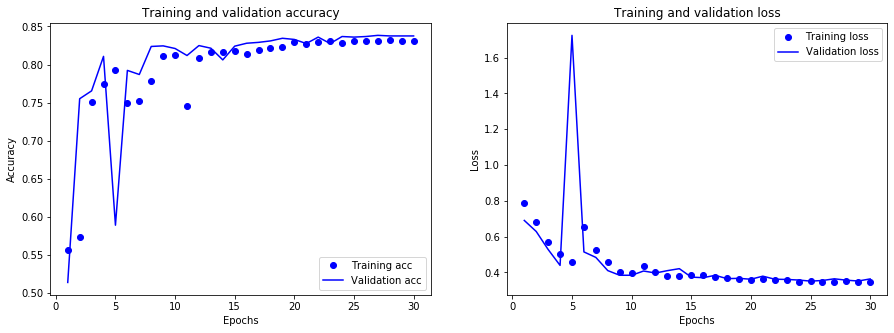

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = historyP.history['acc']
val_acc = historyP.history['val_acc']
loss = historyP.history['loss']
val_loss = historyP.history['val_loss']

epochs = range(1, len(acc) + 1)

f = plt.figure(figsize=(15,5))

ax1 = f.add_subplot(121)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.legend()
ax1.title.set_text('Training and validation accuracy')

ax2 = f.add_subplot(122)
ax2.title.set_text('Generated Synthetic Graph')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.legend()
ax2.title.set_text('Training and validation loss')

plt.show()

### Test and evaluate model accuracy

In [18]:
# Extract true labels
_, ytest_true = create_input_data(dftest_embedded_shuf, tokenizer, max_len)

In [19]:
accr = modelP.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

6524/6524 [==============================] - 17s 3ms/step
Test set
  Loss: 0.3528
  Accuracy: 0.8308


In [20]:
y_pred = modelP.predict_classes(X_test, batch_size=32, verbose=1)

6524/6524 [==============================] - 17s 3ms/step


In [21]:
y_predscr = modelP.predict(X_test, verbose=1)

predpos = np.count_nonzero(y_predscr[:,1] > 0.5)
pred_allpos = predpos / len(y_predscr)
print('Percentage of Positives: {:0.4f}'.format(pred_allpos))

6524/6524 [==============================] - 17s 3ms/step
Percentage of Positives: 0.3473


In [22]:
# lr = 0.005
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy:', accuracy_score(ytest_true, y_pred))
print('Recall:', recall_score(ytest_true, y_pred))
print('Precision:', precision_score(ytest_true, y_pred))
print('F1 score:', f1_score(ytest_true, y_pred))
print('\n clasification report:\n', classification_report(ytest_true, y_pred))
print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))

tn, fp, fn, tp = confusion_matrix(ytest_true, y_pred).ravel()
print(tn, fp, fn, tp)
fpr = fp / (fp+tn)
fpr

Accuracy: 0.8307786633966892
Recall: 0.6781115879828327
Precision: 0.9761694616063548
F1 score: 0.8002894356005787

 clasification report:
               precision    recall  f1-score   support

           0       0.75      0.98      0.85      3262
           1       0.98      0.68      0.80      3262

    accuracy                           0.83      6524
   macro avg       0.86      0.83      0.83      6524
weighted avg       0.86      0.83      0.83      6524


 confusion matrix:
 [[3208   54]
 [1050 2212]]
3208 54 1050 2212


0.01655426118945432

In [56]:
fp_classifier = []    
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for percent in percentages:
    tau_threshold = percent
    ytau_pred = (y_predscr[:,0] < tau_threshold).astype(int)
    tn_tmp, fp_tmp, fn_tmp, tp_tmp = confusion_matrix(ytest_true, ytau_pred).ravel()
    tn_tmp, fp_tmp, fn_tmp, tp_tmp 
    fpr_tmp = fp_tmp / (fp_tmp+tn_tmp)
    fp_classifier.append(fpr_tmp)
    
fp_classifier.insert(0,0)
fp_classifier

[0,
 0.002452483139178418,
 0.010423053341508276,
 0.013182096873083998,
 0.015634580012262415,
 0.01655426118945432,
 0.019619865113427344,
 0.7529123237277744,
 0.7529123237277744,
 0.753525444512569,
 1.0]

6524


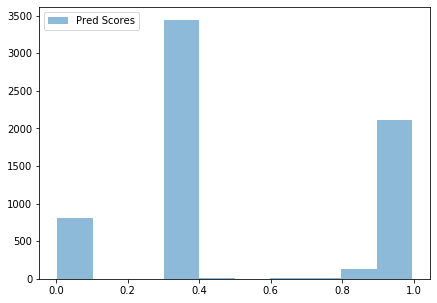

In [68]:
import matplotlib.pyplot as plt

scores = y_predscr[:,1] # classifier atk scores
# def showscore(scores):
fig = plt.figure(figsize=(7,5))
print(len(scores))
plt.hist(scores, bins = 10, alpha=0.5, label='Pred Scores') 
#     plt.hist(scoretype[scores][scoretype['Attack'] == 1], bins = 10, alpha=0.5, label='attacker')
plt.legend(loc='upper left')
plt.show()
    
# showscore(y_predscr) # P scores

In [72]:
print(0.5**5)
print(0.25**5)
print(0.75**5)
print(0.5**5 * len(df_test))
print(0.25**5* len(df_test))
print(0.75**5* len(df_test))

0.03125
0.0009765625
0.2373046875
203.875
6.37109375
1548.17578125
